<a href="https://colab.research.google.com/github/wushidiguo/keras-notes/blob/master/RNN_for_temperature_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir jena_climate
!cd jena_climate
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2019-11-10 00:16:38--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.100.69
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.100.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.47MB/s    in 2.4s    

2019-11-10 00:16:47 (5.47 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [0]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [0]:
import os

fname = "jena_climate_2009_2016.csv"

f =open(fname)
data = f.read()
f.close()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [0]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  float_data[i, :] = values

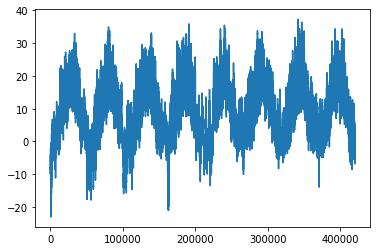

In [0]:
import matplotlib.pyplot as plt

temp = float_data[:, 1] 
plt.plot(range(len(temp)), temp)

In [0]:
mean = float_data[: 200000].mean(axis=0)
float_data -= mean
std = float_data[: 200000].std(axis=0)
float_data /= std

In [0]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      # 取值超过max_index后，进行重置。
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    # (smaples, timesteps, data)
    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows, )))
    for j, row in enumerate(rows):
      indices = range(row - lookback, row, step)
      samples[j] = data[indices]
      targets[j] = data[row + delay][1]
    yield samples, targets  

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [0]:
# baseline:即预测每天的气温与24小时前相同
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    # mae:mean absolute error
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss="mae")

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 21ms/step - loss: 1.5443 - val_loss: 0.9543
Epoch 2/20
500/500 [==============================] - 11s 21ms/step - loss: 0.5308 - val_loss: 0.4331
Epoch 3/20
500/500 [==============================] - 11s 21ms/step - loss: 0.3095 - val_loss: 0.3029
Epoch 4/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2731 - val_loss: 0.3050
Epoch 5/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2590 - val_loss: 0.3217
Epoch 6/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2485 - val_loss: 0.3315
Epoch 7/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2407 - val_loss: 0.3107
Epoch 8/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2341 - val_loss: 0.3210
Epoch 9/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2300 - val_loss: 0.3154
Epoch 10/20
500/500 [==============================] - 10s 21ms/step - loss: 0.225

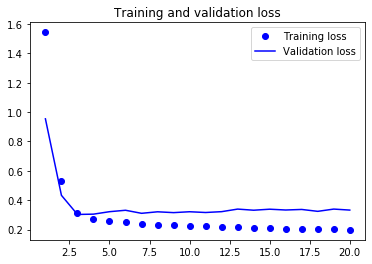

In [0]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss="mae")

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
500/500 [==============================] - 183s 365ms/step - loss: 0.2995 - val_loss: 0.2737
Epoch 2/20
500/500 [==============================] - 181s 362ms/step - loss: 0.2874 - val_loss: 0.2678
Epoch 3/20
500/500 [==============================] - 179s 358ms/step - loss: 0.2784 - val_loss: 0.2675
Epoch 4/20
500/500 [==============================] - 179s 358ms/step - loss: 0.2714 - val_loss: 0.2618
Epoch 5/20
500/500 [==============================] - 177s 355ms/step - loss: 0.2658 - val_loss: 0.2601
Epoch 6/20
500/500 [==============================] - 177s 354ms/step - loss: 0.2608 - val_loss: 0.2610
Epoch 7/20
500/500 [==============================] - 177s 353ms/step - loss: 0.2557 - val_loss: 0.2648
Epoch 8/20
500/500 [==============================] - 176s 352ms/step - loss: 0.2508 - val_loss: 0.2693
Epoch 9/20
500/500 [==============================] - 176s 352ms/step - lo

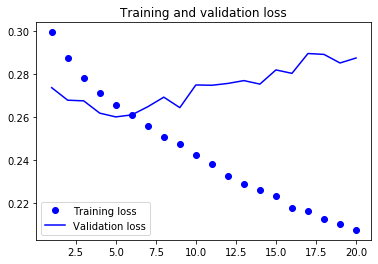

In [0]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [0]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss="mae")
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/40
500/500 [==============================] - 205s 410ms/step - loss: 0.3396 - val_loss: 0.2764
Epoch 2/40
500/500 [==============================] - 203s 405ms/step - loss: 0.3159 - val_loss: 0.2727
Epoch 3/40
500/500 [==============================] - 201s 402ms/step - loss: 0.3089 - val_loss: 0.2732
Epoch 4/40
500/500 [==============================] - 200s 400ms/step - loss: 0.3047 - val_loss: 0.2714
Epoch 5/40
500/500 [==============================] - 200s 400ms/step - loss: 0.3031 - val_loss: 0.2673
Epoch 6/40
500/500 [==============================] - 198s 395ms/step - loss: 0.2990 - val_loss: 0.2689
Epoch 7/40
500/500 [==============================] - 197s 394ms/step - loss: 0.2970 - val_loss: 0.2648
Epoch 8/40
500/500 [==============================] - 195s 390ms/step - loss: 0.2954 - val_loss: 0.2684
Epoch 9/40
500/500 [==============================] 

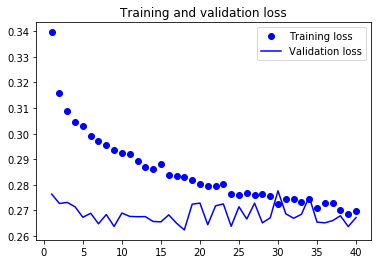

In [0]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [0]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.GRU(64, activation="relu", dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss="mae")
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

NameError: ignored